<a href="https://colab.research.google.com/github/dansten/Portfolio/blob/main/austin_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.cloud import bigquery
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

project_id = 'sql-portfolio'
client = bigquery.Client(project=project_id)

In [50]:
#!pip install google-cloud 
#!pip install --upgrade google-cloud-bigquery[pandas] 
#!pip install google-cloud-storage

In [51]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [52]:
SERVICE_ACCOUNT= 'ds_acc'
JSON_FILE_NAME = '/content/drive/MyDrive/sql-portfolio-fdb03de9bfd5.json'
GCP_PROJECT_ID = 'sql-portfolio'

In [53]:
import matplotlib.pyplot as plt

In [54]:
#Useful methods
def query_to_dataframe(q):
  return client.query(q).result().to_dataframe()

def get_schema(table):
  return client.get_table(table).schema

In [55]:
table = 'bigquery-public-data.austin_bikeshare.bikeshare_stations'
get_schema(table)

[SchemaField('station_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('status', 'STRING', 'NULLABLE', None, ()),
 SchemaField('address', 'STRING', 'NULLABLE', None, ()),
 SchemaField('alternate_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('city_asset_number', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('property_type', 'STRING', 'NULLABLE', None, ()),
 SchemaField('number_of_docks', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('power_type', 'STRING', 'NULLABLE', None, ()),
 SchemaField('footprint_length', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('footprint_width', 'FLOAT', 'NULLABLE', None, ()),
 SchemaField('notes', 'STRING', 'NULLABLE', None, ()),
 SchemaField('council_district', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('modified_date', 'TIMESTAMP', 'NULLABLE', None, ())]

In [56]:
table = 'bigquery-public-data.austin_bikeshare.bikeshare_trips'
get_schema(table)

[SchemaField('trip_id', 'INTEGER', 'NULLABLE', 'Numeric ID of bike trip', ()),
 SchemaField('subscriber_type', 'STRING', 'NULLABLE', 'Type of the Subscriber', ()),
 SchemaField('bikeid', 'STRING', 'NULLABLE', 'ID of bike used', ()),
 SchemaField('start_time', 'TIMESTAMP', 'NULLABLE', 'Start timestamp of trip', ()),
 SchemaField('start_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for start station', ()),
 SchemaField('start_station_name', 'STRING', 'NULLABLE', 'Station name for start station', ()),
 SchemaField('end_station_id', 'STRING', 'NULLABLE', 'Numeric reference for end station', ()),
 SchemaField('end_station_name', 'STRING', 'NULLABLE', 'Station name for end station', ()),
 SchemaField('duration_minutes', 'INTEGER', 'NULLABLE', 'Time of trip in minutes', ())]

1. What bikes are most popular?

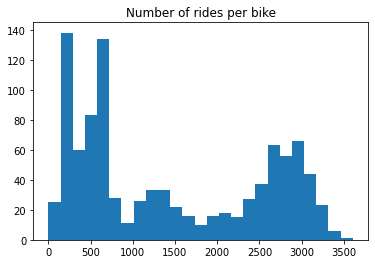

In [57]:
q1 = """
  SELECT 
    bikeid, 
    FLOOR(COUNT(trip_id)) AS num_trips,
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  GROUP BY bikeid
  ORDER BY num_trips DESC
"""
bike_df = query_to_dataframe(q1)
plt.hist(bike_df.num_trips, bins =25)
plt.title("Number of rides per bike")
plt.show()

We can see that we have three kind of groups, let's call these low, medium and high usage. Bikes that have been used 0-750 times (low), bikes that have been used 750-2250 (medium) and bikes that have been used 2250-3500 times (high). 

Let's look at the average ride time for each of these groups.

In [58]:
# we want, usage_group, avg_ur
q2 = """
  SELECT 
    bikeid,
    CASE 
        WHEN num_trips > 2250 THEN 'High'
        WHEN num_trips < 750 THEN 'Low'
        ELSE 'Medium'
    END
    AS usage_group,
    avg_dur 
    FROM (
        SELECT 
            bikeid, 
            FLOOR(COUNT(trip_id)) AS num_trips,
            FLOOR(AVG(duration_minutes)) AS avg_dur
        FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
        GROUP BY bikeid
    )
"""
bike_group_df = query_to_dataframe(q2)

In [59]:
bike_group_df.head()

,bikeid,usage_group,avg_dur
0,248,Medium,39.0
1,446,High,28.0
2,203,High,29.0
3,101,High,28.0
4,242,Medium,30.0


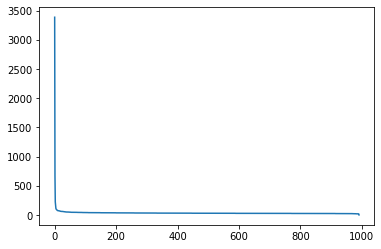

In [60]:
#First, let's plot to see if we have any outliers
#We sort 
import numpy as np
bike_group_df = bike_group_df.sort_values(['avg_dur'], ascending=False)
bike_group_df.shape[0]
x = np.linspace(0,bike_group_df.shape[0],bike_group_df.shape[0])
plt.plot(x,bike_group_df.avg_dur)
plt.show()

As we can see, we have one or possible a few outliers in the begining, there are many ways we can handle these, e.g., linear interpolation, cubic interpolation etc, for this time we are just going to remove them. However, it would probably be a good idea to, at some point, study why we have these outliers.

In [61]:
bike_group_df = bike_group_df.tail(bike_group_df.shape[0] -4)

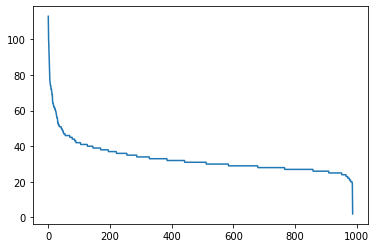

In [62]:
x = np.linspace(0,bike_group_df.shape[0],bike_group_df.shape[0])
plt.plot(x,bike_group_df.avg_dur)
plt.show()

That looks much better. We still have some outliers, but these seem more reasonable, so we will keep them.

In [63]:
low_df = bike_group_df[bike_group_df['usage_group'] == 'Low']
medium_df = bike_group_df[bike_group_df['usage_group'] == 'Medium']
high_df = bike_group_df[bike_group_df['usage_group'] == 'High']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

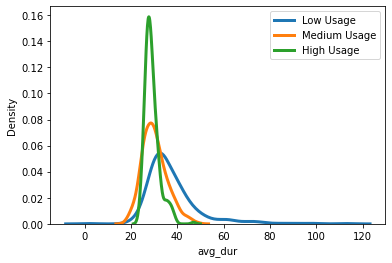

In [64]:
import seaborn as sns
sns.distplot(low_df['avg_dur'], hist=False, kde = True, 
             kde_kws = {'linewidth': 3},
             label = "Low Usage")
sns.distplot(medium_df['avg_dur'], hist=False, kde = True, 
             kde_kws = {'linewidth': 3},
             label = "Medium Usage")
sns.distplot(high_df['avg_dur'], hist=False, kde = True, 
             kde_kws = {'linewidth': 3},
             label = "High Usage")
plt.legend(prop={'size':10})
plt.show()

So we can see that the mean for the medium and high usage is approximately the same, around 30 minutes, whilst for the low usage bikes it is a bit higher, around 35 minutes. 
We can also note, that the low usage bikes have a much higher variance than medium and high usage. 

Now we will try to understand these groups even further. Can we find similar travel patterns? Let's take a look.

In [65]:
#What routes are most poopular for each group
q3 = """
  SELECT 
    CONCAT(start_station_id, '-', end_station_id) as route, 
    start_station_id,
    end_station_id,
    COUNT(trip_id) AS num_trips
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  GROUP BY route, start_station_id, end_station_id
  ORDER BY num_trips DESC
  LIMIT 25
"""
top_routes_df = query_to_dataframe(q3)
top_routes_df.head()

,route,start_station_id,end_station_id,num_trips
0,2575-2575,2575,2575,15257
1,3798-3798,3798,3798,14346
2,3798-3794,3798,3794,12714
3,3794-3798,3794,3798,12294
4,2707-2707,2707,2707,11185


In [66]:
#Add in high, in medium and in low,

In [67]:
#trip_id route bike_usage_group 
q4 = """
    SELECT 
        COUNT(trip_id) as num_trips,
        CONCAT(start_station_id, '-', end_station_id) as route, 
        bikeid
      FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
      WHERE bikeid IN
        (
            SELECT 
                bikeid
            FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
            GROUP BY bikeid
            HAVING COUNT(trip_id) > 2250
        ) AND start_station_id IS NOT NULL AND end_station_id IS NOT NULL
      GROUP BY route, bikeid
      ORDER BY num_trips DESC
      LIMIT 50
"""
q5 = """
    SELECT 
        COUNT(trip_id) as num_trips,
        CONCAT(start_station_id, '-', end_station_id) as route, 
        bikeid
      FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
      WHERE bikeid IN
        (
            SELECT 
                bikeid
            FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
            GROUP BY bikeid
            HAVING COUNT(trip_id) BETWEEN 750 AND 2250
        ) AND start_station_id IS NOT NULL AND end_station_id IS NOT NULL
      GROUP BY route, bikeid
      ORDER BY num_trips DESC
      LIMIT 50
"""

q6 = """
    SELECT 
        COUNT(trip_id) as num_trips,
        CONCAT(start_station_id, '-', end_station_id) as route, 
        bikeid
      FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
      WHERE bikeid IN
        (
            SELECT 
                bikeid
            FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
            GROUP BY bikeid
            HAVING COUNT(trip_id) < 750
        ) AND start_station_id IS NOT NULL AND end_station_id IS NOT NULL
      GROUP BY route, bikeid
      ORDER BY num_trips DESC
      LIMIT 50
"""

high_routes_df = query_to_dataframe(q4)
medium_routes_df = query_to_dataframe(q5)
low_routes_df = query_to_dataframe(q6)

In [68]:
high_routes_df.head()

,num_trips,route,bikeid
0,325,3798-3798,853
1,170,3798-3798,937
2,166,3798-3798,559
3,95,2562-2562,774
4,80,3793-3793,621


In [69]:
medium_routes_df.head()

,num_trips,route,bikeid
0,234,3798-3798,2351
1,101,3798-3798,1585
2,88,3798-3798,2277
3,84,3798-3798,1927
4,79,3838-3838,280


In [70]:
low_routes_df.head()

,num_trips,route,bikeid
0,62,3798-3798,035G
1,42,3794-3798,095G
2,41,3798-3798,1797
3,39,3798-3794,095G
4,36,4061-4061,126G


In [71]:
#Now we can see if the routes of high usage bikes and  are different from low
#we are going to use pandas to see if a route is included in both th
high_routes_df['in_low'] = high_routes_df.isin(low_routes_df['route'])['route']
high_routes_df

,num_trips,route,bikeid,in_low
0,325,3798-3798,853,True
1,170,3798-3798,937,False
2,166,3798-3798,559,True
3,95,2562-2562,774,False
4,80,3793-3793,621,False
5,67,2575-2575,898,False
6,65,3797-3797,869,False
7,63,3798-3798,453,False
8,59,3798-3794,88,True
9,57,3798-3798,288,False


In [72]:
medium_routes_df['in_low'] = medium_routes_df.isin(low_routes_df['route'])['route']
medium_routes_df

,num_trips,route,bikeid,in_low
0,234,3798-3798,2351,True
1,101,3798-3798,1585,False
2,88,3798-3798,2277,True
3,84,3798-3798,1927,False
4,79,3838-3838,280,False
5,77,3798-3798,2887,False
6,74,3798-3798,1434,False
7,73,3798-3798,174,False
8,63,3798-3794,1277,True
9,60,3798-3798,1786,False


In [73]:
percentage_in_high = int(round(high_routes_df['in_low'].value_counts()[1]/high_routes_df['in_low'].value_counts()[0],2)*100)
percentage_in_medium = int(round(medium_routes_df['in_low'].value_counts()[1]/medium_routes_df['in_low'].value_counts()[0],2)*100)
print(f"Percentage of top 50 low usage routes in high usage routes: {percentage_in_high}%")
print(f"Percentage of top 50 low usage routes in medium usage routes: {percentage_in_medium}%")

Percentage of top 50 low usage routes in high usage routes: 14%
Percentage of top 50 low usage routes in medium usage routes: 14%


So there is definietly some difference in which routes are being taken by the high and medium usage bikes, compared to the low usage bikes. What about between the high and medium?

In [74]:
high_routes_df['in_medium'] = high_routes_df.isin(medium_routes_df['route'])['route']
percentage_in_high_medium = int(round(high_routes_df['in_medium'].value_counts()[1]/high_routes_df['in_medium'].value_counts()[0],2)*100)
print(f"Percentage of top 50 low usage routes in high usage routes: {percentage_in_high_medium}%")

Percentage of top 50 low usage routes in high usage routes: 39%


That means that there is more correlation between the high and medium usage bikes, than the low, but even here there is a difference.
Thus, we can assure that the high, medium and low usage bikes are located at mainly different parts of Austin. We could dive even further into this, but instead let's see if we can we find some understanding of short time users (we'll call these customers) and long time users (subcribers).

Let's what different users we have:

In [75]:
q7 = """
  SELECT DISTINCT
    subscriber_type
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  GROUP By subscriber_type
"""
sub_type_df = query_to_dataframe(q7)
sub_type_df

,subscriber_type
0,Walk Up
1,24-Hour Kiosk (Austin B-cycle)
2,Annual Membership (Austin B-cycle)
3,Founding Member (Austin B-cycle)
4,Local365
...,...
72,Local365 Youth (age 13-17 riders)- 1/2 off Spe...
73,PROHIBITED
74,RESTRICTED
75,Annual (Omaha B-cycle)


We have 77 unique types of membership/subscribers. For the purpose of this project, we are going to make it easy for us, and say that every type that continas the word "annual" is going to be a subscriber, and else a customer.

In [99]:
q8 = """
  SELECT 
    COUNT(trip_id) AS num_trips,
    EXTRACT(MONTH from start_time) AS trip_month,
    CASE 
        WHEN subscriber_type LIKE '%Annual%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Local%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Semester%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Student%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Founding%' THEN 'subscriber'
        ELSE 'customer'
    END 
    AS sub_type
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  GROUP BY trip_month, sub_type 
  ORDER BY trip_month
"""
num_trips_users = query_to_dataframe(q8)

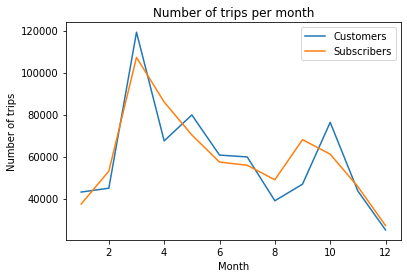

In [101]:
months = num_trips_users['trip_month'].unique().tolist()
customer_trips = num_trips_users.loc[num_trips_users['sub_type'] == 'customer']['num_trips']
subscriber_trips = num_trips_users.loc[num_trips_users['sub_type'] == 'subscriber']['num_trips']

plt1, = plt.plot(months, customer_trips)
plt2, = plt.plot(months, subscriber_trips)

plt.legend((plt1,plt2), ("Customers","Subscribers"))
plt.title("Number of trips per month")
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.show()

We can clearly see that there is something going on in March in Austin; during this time of the year, the number of trips for both groups are significantly higher than the rest of the year. May and October are also quite popular months, but during the summer and winter months, the usage drops.

In [102]:
q9 = """
  SELECT 
    ROUND(AVG(duration_minutes),2) AS avg_dur,
    EXTRACT(MONTH from start_time) AS trip_month,
    CASE 
        WHEN subscriber_type LIKE '%Annual%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Local%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Semester%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Student%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Founding%' THEN 'subscriber'
        ELSE 'customer'
    END 
    AS sub_type
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  GROUP BY trip_month, sub_type 
  ORDER BY trip_month
"""
avg_dur_users = query_to_dataframe(q9)

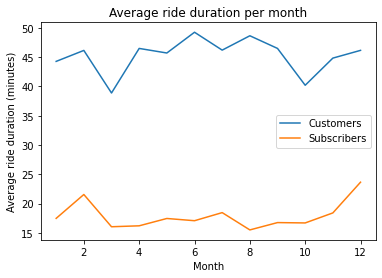

In [103]:
customer_dur = avg_dur_users.loc[avg_dur_users['sub_type'] == 'customer']['avg_dur']
subscriber_dur = avg_dur_users.loc[avg_dur_users['sub_type'] == 'subscriber']['avg_dur']

plt1, = plt.plot(months, customer_dur)
plt2, = plt.plot(months, subscriber_dur)

plt.legend((plt1,plt2), ("Customers","Subscribers"))
plt.title("Average ride duration per month")
plt.xlabel("Month")
plt.ylabel("Average ride duration (minutes)")
plt.show()

On the other hand, the most popular month looking at number of trips, March, has the lowest average ride duration during the year. A thesis might be, that there are some events going on in Austin in March each year, perhaps downtown, where more people gather but don't travel very far. Would have to invesgate this further though, with external data, to confirm.

In [108]:
q10 = """
  SELECT 
    SUM(duration_minutes) AS tot_dur,
    EXTRACT(MONTH from start_time) AS trip_month,
    CASE 
        WHEN subscriber_type LIKE '%Annual%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Local%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Semester%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Student%' THEN 'subscriber'
        WHEN subscriber_type LIKE '%Founding%' THEN 'subscriber'
        ELSE 'customer'
    END 
    AS sub_type
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  GROUP BY trip_month, sub_type 
  ORDER BY trip_month
"""
culm_duration_df = query_to_dataframe(q10)

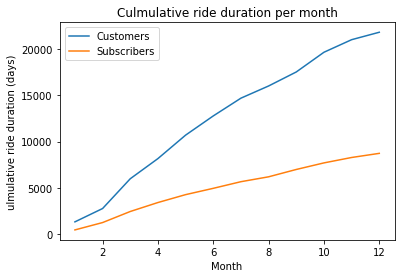

In [115]:
culm_customer_dur = culm_duration_df.loc[culm_duration_df['sub_type'] == 'customer']['tot_dur']
cul_subscriber_dur = culm_duration_df.loc[culm_duration_df['sub_type'] == 'subscriber']['tot_dur']

plt1, = plt.plot(months, culm_customer_dur.cumsum()/(60*24))
plt2, = plt.plot(months, cul_subscriber_dur.cumsum()/(60*24))

plt.legend((plt1,plt2), ("Customers","Subscribers"))
plt.title("Culmulative ride duration per month")
plt.xlabel("Month")
plt.ylabel("ulmulative ride duration (days)")
plt.show()

Last but not least, we can conclude that on a year, customers ride more than twice as much as subscribers. Both these groups expect quite linear trends per month, which can be helpful when trying to predict future usage and ride duration.